In [311]:
# 한글폰트
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
!apt-get update -qq
!apt-get install fonte-nanum* -qq

import matplotlib.font_manager as fm
fm._rebuild()

# 한글 폰트 확인하기
for fontInfo in fm.fontManager.ttflist:
  if 'Nanum' in fontInfo.name:
    print(fontInfo.name + ' = '+fontInfo.fname)

plt.rc('font', family = 'NanumGothic')

# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

E: Unable to locate package fonte-nanum*
E: Couldn't find any package by glob 'fonte-nanum*'
E: Couldn't find any package by regex 'fonte-nanum*'
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothic.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareR.ttf


In [312]:
# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


# 데이터 불러오기
train = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
val = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_자율평가데이터.xlsx')
test = pd.read_excel('/content/drive/MyDrive/빅콘테스트/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_평가데이터_update_210831.xlsx')

In [313]:
# train과 val 합쳐주기
df = pd.concat([train, val], axis = 0)

# column 편하게 바꿔주기
df = df.rename(columns = {'REG_DATE':'기준일', 'P_TYPE':'제품구분','CTRY_1':'제조국','CTRY_2':'수출국',
                        'P_PURPOSE':'수입용도','CATEGORY_1':'중분류명 카테고리',
                        'CATEGORY_2':'어종','P_NAME':'상세어종','P_IMPORT_TYPE':'수입형태',
                        'P_PRICE':'target'})

In [314]:
# 데이터에서 연어만 뽑아 내기
df = df[df['상세어종'] == '연어']

## 데이터 EDA

In [315]:
# 시간별 데이터로 column 만들어 주기
df['year'] = df['기준일'].dt.year
df['month'] = df['기준일'].dt.month
df['day'] = df['기준일'].dt.day
df['week'] = df['기준일'].dt.week

print(df.columns)

Index(['기준일', '제품구분', '제조국', '수출국', '수입용도', '중분류명 카테고리', '어종', '상세어종', '수입형태',
       'target', 'year', 'month', 'day', 'week'],
      dtype='object')


In [316]:
#  이상치 제거를 IQR 방법을 통해서 제거해 보도록 하자.
def get_outlier(df=None, column=None, weight=4.0):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

delete_index = get_outlier(df = df, column = 'target', weight = 4.5)
print(df.loc[delete_index, :])

# index를 찾아서 전부 nan값으로 변경해준다.
for i in delete_index:
  df.loc[i,'target'] = np.nan

# 자사제품제조용
for i in df.index:
  if i in delete_index:
    df.loc[i,'target'] = df[(df['month'] == df.loc[i,'month']) & (df['수입용도'] == df.loc[i,'수입용도']) & (df['제조국'] == '노르웨이')]['target'].mean()

print('결측치를 채운 이후',df.isnull().sum().sum())

             기준일 제품구분   제조국   수출국     수입용도  ...     target  year month day  week
14240 2017-05-15  수산물  노르웨이  노르웨이  자사제품제조용  ...  62.457202  2017     5  15    20
14444 2017-05-22  수산물  노르웨이  노르웨이  자사제품제조용  ...  49.777500  2017     5  22    21
14639 2017-05-29  수산물  노르웨이  노르웨이  자사제품제조용  ...  40.521693  2017     5  29    22
14834 2017-06-05  수산물  노르웨이  노르웨이  자사제품제조용  ...  51.394008  2017     6   5    23
15054 2017-06-12  수산물  노르웨이  노르웨이  자사제품제조용  ...  43.791678  2017     6  12    24
15244 2017-06-19  수산물  노르웨이  노르웨이  자사제품제조용  ...  48.550884  2017     6  19    25
15449 2017-06-26  수산물  노르웨이  노르웨이  자사제품제조용  ...  43.481666  2017     6  26    26
15663 2017-07-03  수산물  노르웨이  노르웨이  자사제품제조용  ...  50.173407  2017     7   3    27
15859 2017-07-10  수산물  노르웨이  노르웨이  자사제품제조용  ...  52.263797  2017     7  10    28
16051 2017-07-17  수산물  노르웨이  노르웨이  자사제품제조용  ...  47.185995  2017     7  17    29
7762  2020-10-26  수산물  노르웨이  노르웨이  자사제품제조용  ...  46.632093  2020    10  26    44

[11 rows x 14 columns]
결측치를

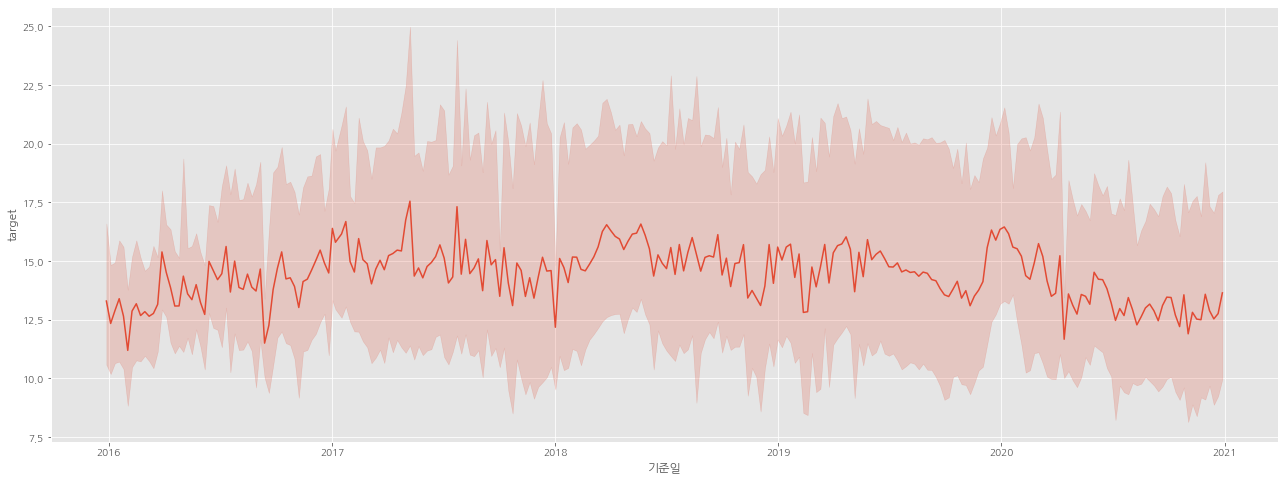

In [317]:
# lineplot으로 그래프 그려보기
plt.figure(figsize = (22,8))
sns.lineplot(data = df, x = '기준일', y = 'target')

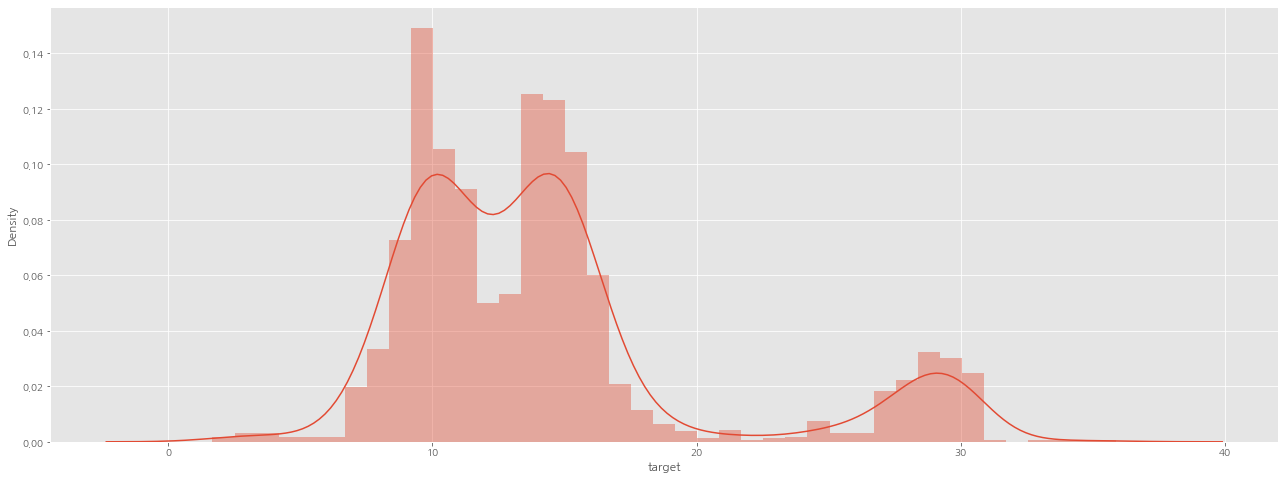

In [318]:
# 밀도 분포를 그려보자.
plt.figure(figsize = (22,8))
sns.distplot(df['target'])

In [319]:
df = df.reset_index(drop = True)

In [320]:
# 냉동이라는 부분은 얼마 없다고 판단한다.
# 그러면 냉동의 데이터를 하나의 변수로 묶어주기로 하자.
for i in df.index:
  if df.loc[i, '수입형태'][:2] == '냉동':
    df.loc[i,'수입형태'] = '냉동'

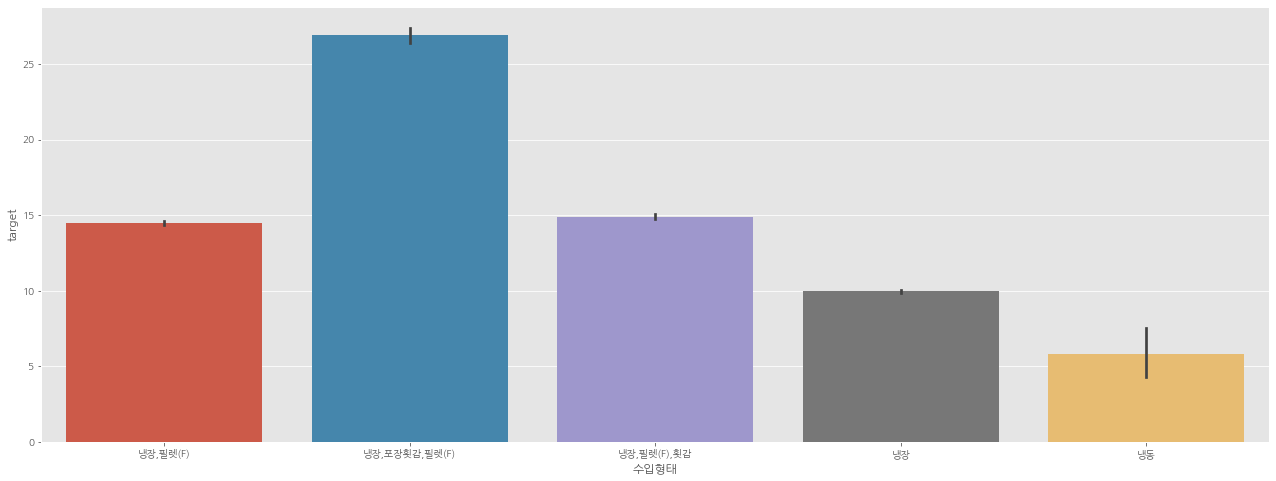

In [321]:
# 수입형태가 잘 바뀌었는지 확인해 본다.
plt.figure(figsize = (22,8))
sns.barplot(data = df, x = '수입형태', y = 'target')

In [322]:
def new_column(df = None):

  연어_수입형태 = set()

  for index in df.index:
    value_list = df.loc[index, '수입형태'].split(',')
    
    연어_수입형태.update(value_list)

  # 고유한 수입형태에 모두 0 넣어주기
  df[list(연어_수입형태)] = 0

  for index in df.index:
    value_list = df.loc[index, '수입형태'].split(',')
    
    for value in value_list:
      df.loc[index, value] = 1

  return df

df = new_column(df = df)

In [323]:
# 필요없는 변수들을 ㅈ전부 제거해준다.
df.drop(['제품구분','중분류명 카테고리','어종','상세어종'], axis = 1, inplace = True)
df

,기준일,제조국,수출국,수입용도,수입형태,target,year,month,day,week,냉동,횟감,필렛(F),냉장,포장횟감
0,2015-12-28,노르웨이,노르웨이,판매용,"냉장,필렛(F)",12.936815,2015,12,28,53,0,0,1,1,0
1,2015-12-28,노르웨이,노르웨이,판매용,"냉장,포장횟감,필렛(F)",19.146755,2015,12,28,53,0,0,1,1,1
2,2015-12-28,노르웨이,노르웨이,판매용,"냉장,필렛(F),횟감",12.082384,2015,12,28,53,0,1,1,1,0
3,2015-12-28,노르웨이,노르웨이,자사제품제조용,"냉장,필렛(F)",13.425826,2015,12,28,53,0,0,1,1,0
4,2015-12-28,노르웨이,노르웨이,판매용,냉장,8.844281,2015,12,28,53,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2020-12-28,노르웨이,노르웨이,자사제품제조용,냉장,8.750000,2020,12,28,53,0,0,0,1,0
1891,2020-12-28,노르웨이,노르웨이,판매용,"냉장,포장횟감,필렛(F)",29.740000,2020,12,28,53,0,0,1,1,1
1892,2020-12-28,노르웨이,노르웨이,판매용,"냉장,필렛(F)",15.290000,2020,12,28,53,0,0,1,1,0
1893,2020-12-28,노르웨이,노르웨이,자사제품제조용,"냉장,필렛(F)",14.260000,2020,12,28,53,0,0,1,1,0


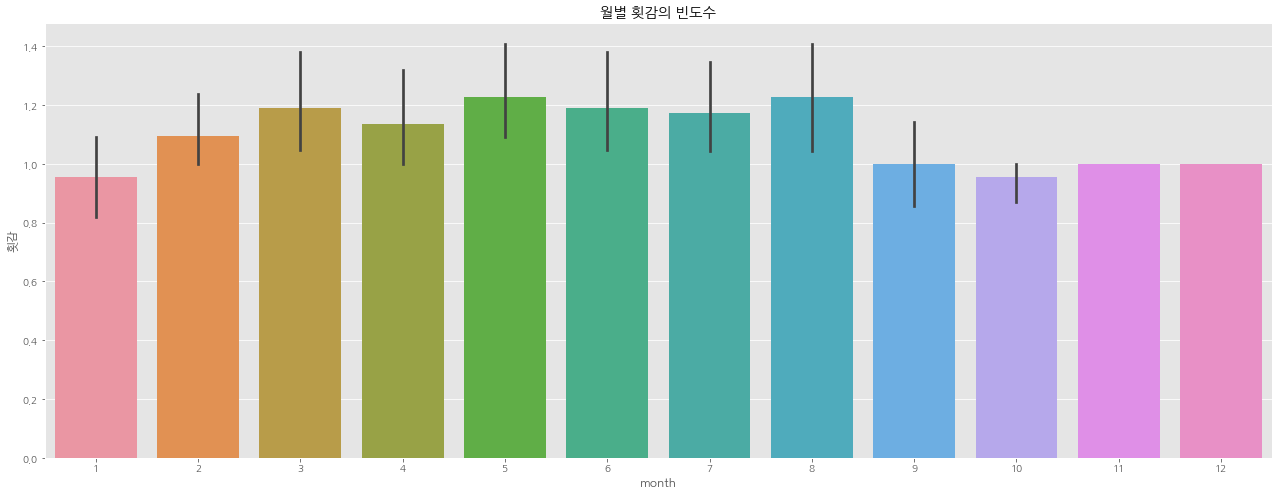

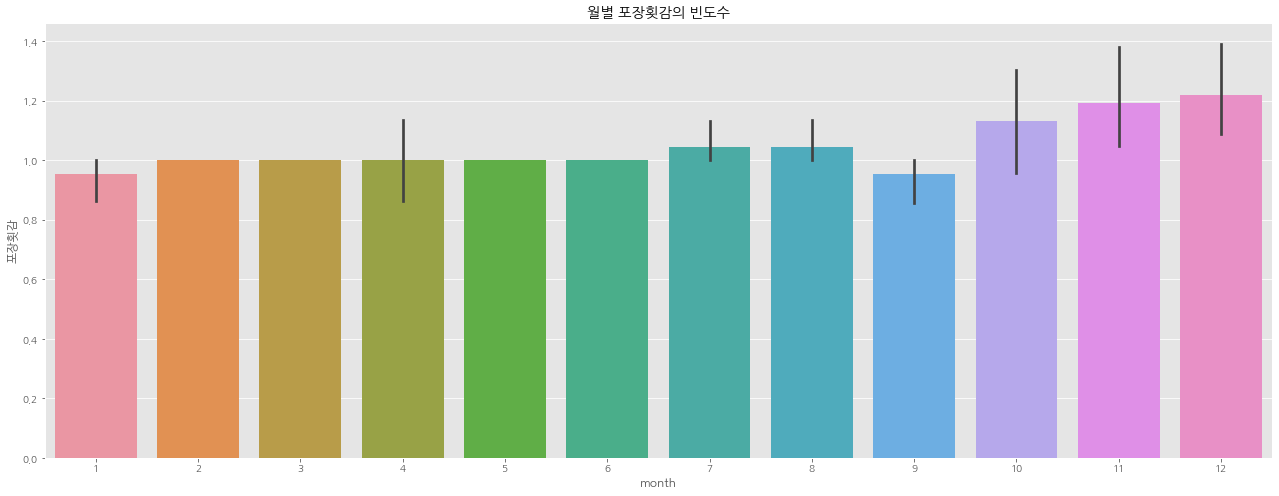

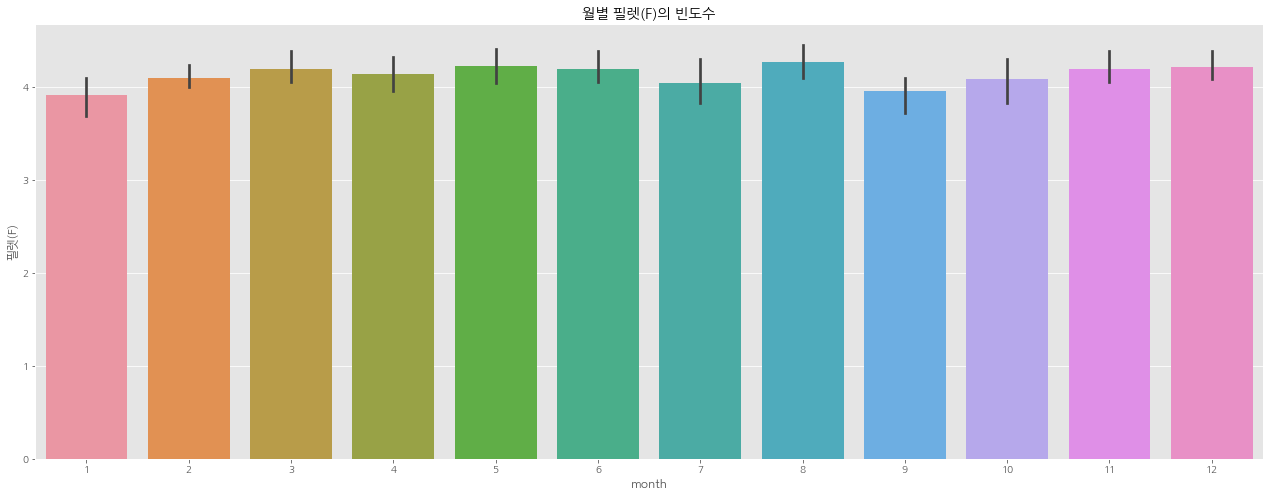

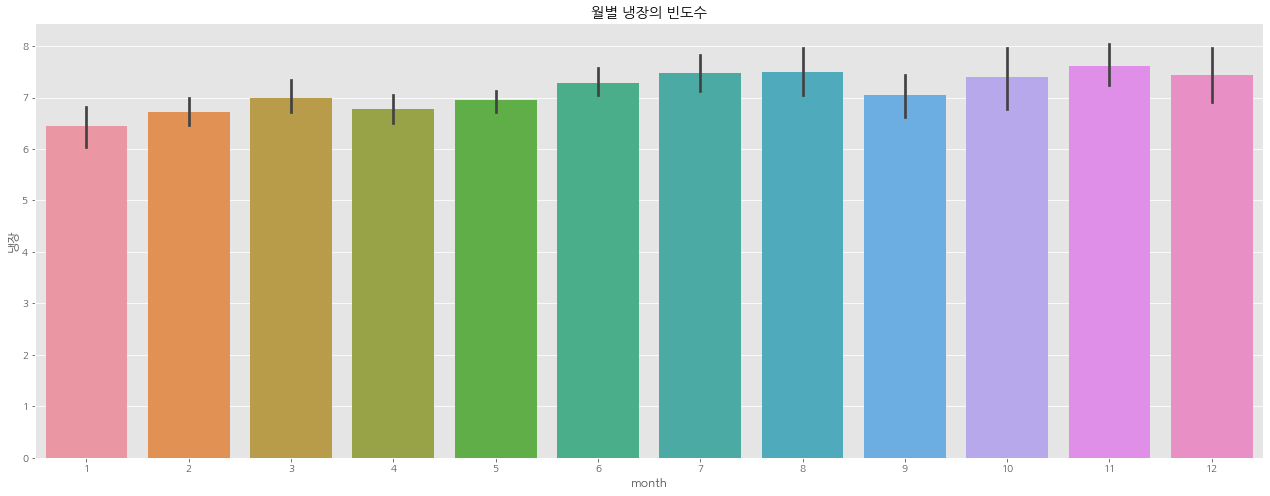

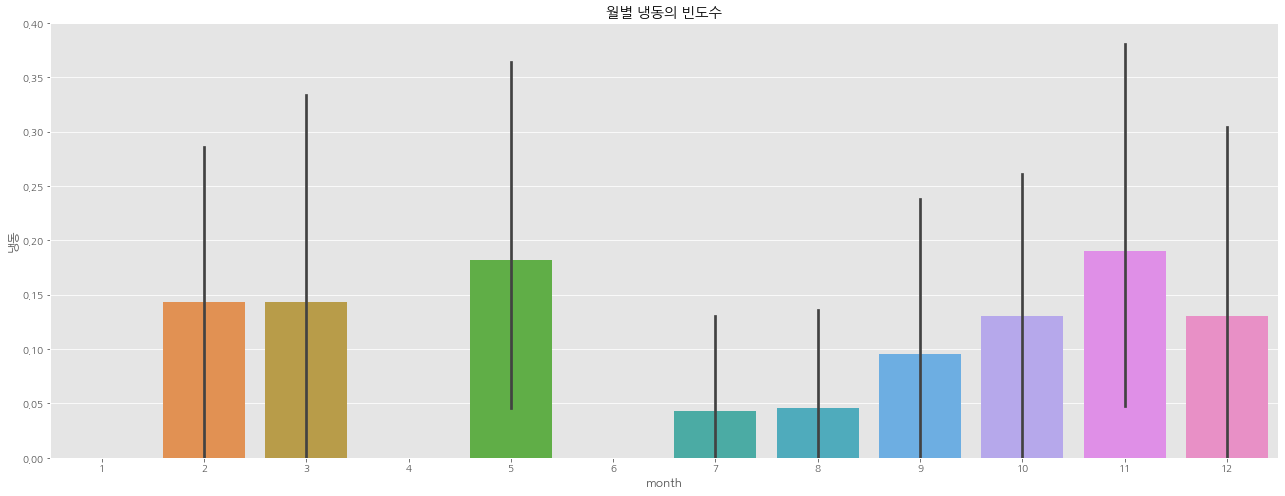

In [324]:
split_수입형태 = df.groupby('기준일')[['횟감'	,'포장횟감'	,'필렛(F)'	,'냉장'	,'냉동']].sum().reset_index()

split_수입형태['year'] = split_수입형태['기준일'].dt.year
split_수입형태['month'] = split_수입형태['기준일'].dt.month
split_수입형태['day'] = split_수입형태['기준일'].dt.day
split_수입형태['week'] = split_수입형태['기준일'].dt.week

target_mean = df.groupby('기준일')['target'].mean().reset_index()

for i in ['횟감'	,'포장횟감'		,'필렛(F)'	,'냉장'	,'냉동']:
  plt.figure(figsize = (22,8))
  sns.barplot(data = split_수입형태, x = 'month', y = i)
  plt.title(f'월별 {i}의 빈도수')
  plt.show()

Text(0.5, 1.0, 'month of target mean')

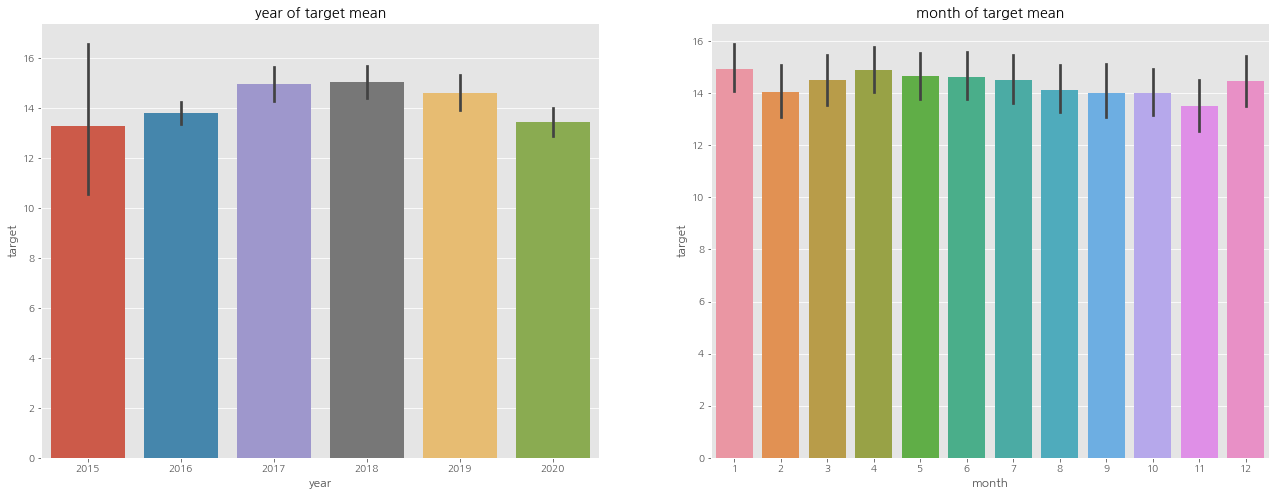

In [325]:
# year, month
fig, ax = plt.subplots(ncols = 2, figsize=  (22,8))
sns.barplot(data = df, x = 'year', y = 'target', ax = ax[0])
sns.barplot(data = df, x = 'month', y = 'target', ax = ax[1])
ax[0].set_title('year of target mean')
ax[1].set_title('month of target mean')

Text(0.5, 1.0, 'week of target mean')

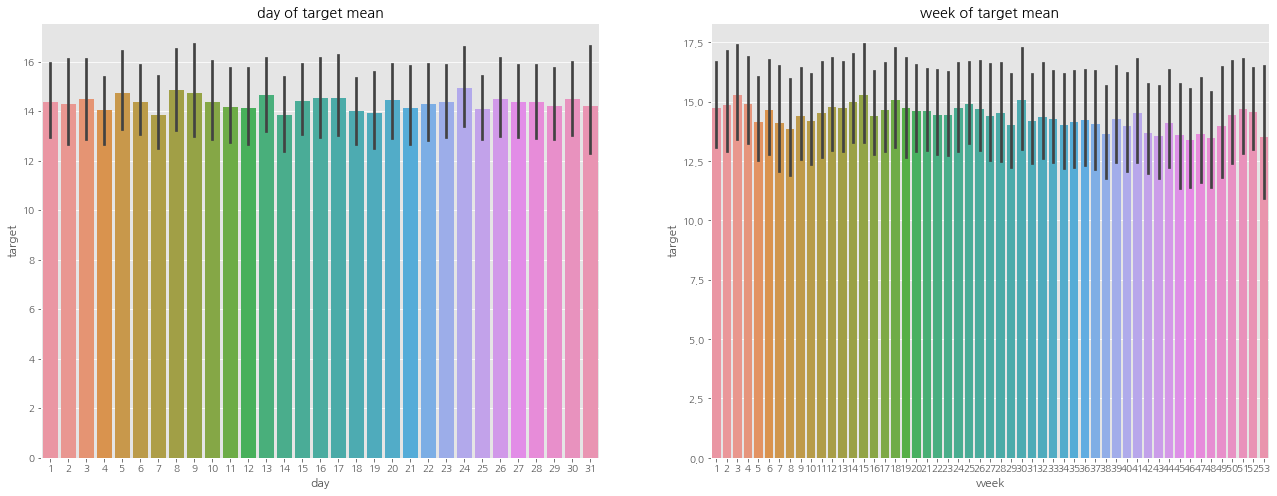

In [326]:
# day, week
fig, ax = plt.subplots(ncols = 2, figsize = (22,8))
sns.barplot(data = df, x = 'day', y = 'target', ax = ax[0])
sns.barplot(data = df, x = 'week', y = 'target', ax = ax[1])
ax[0].set_title('day of target mean')
ax[1].set_title('week of target mean')

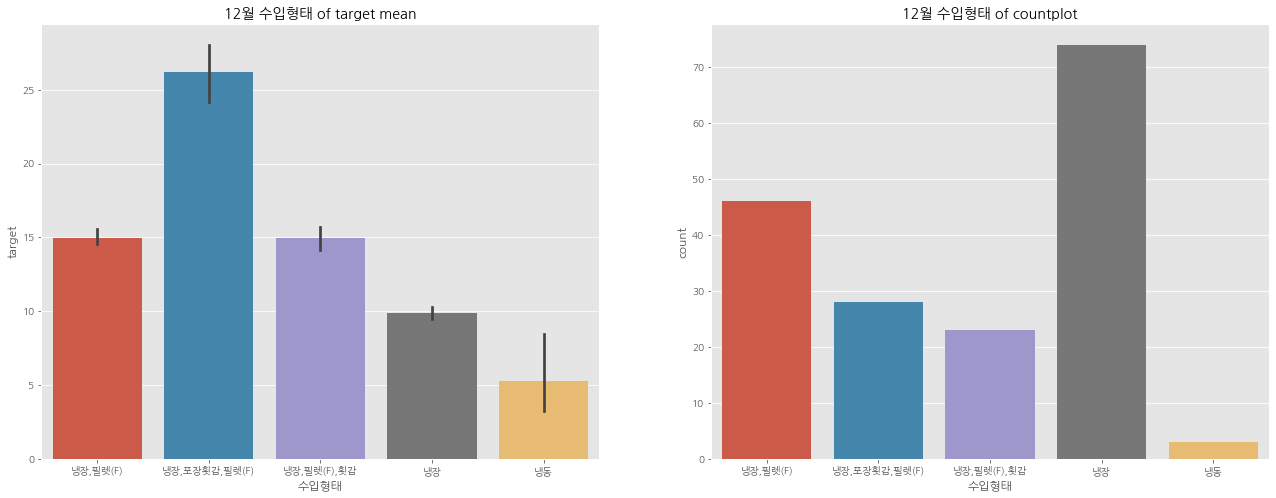

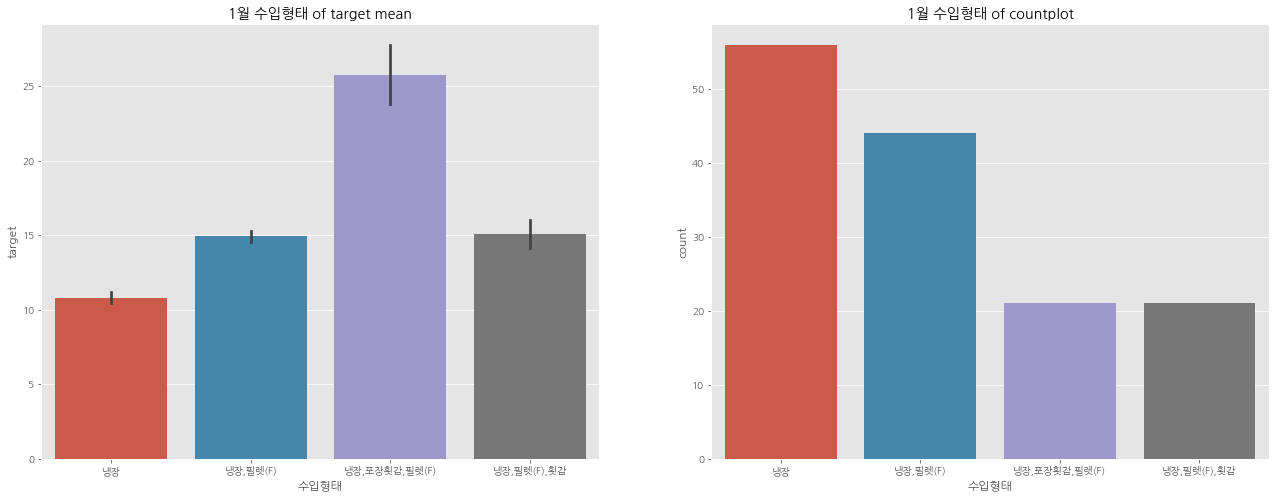

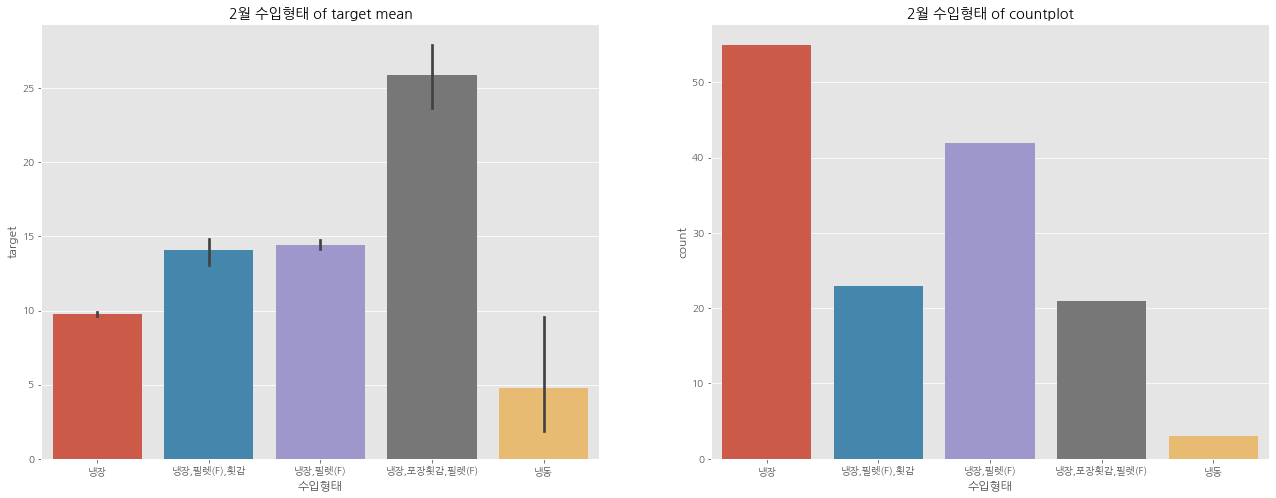

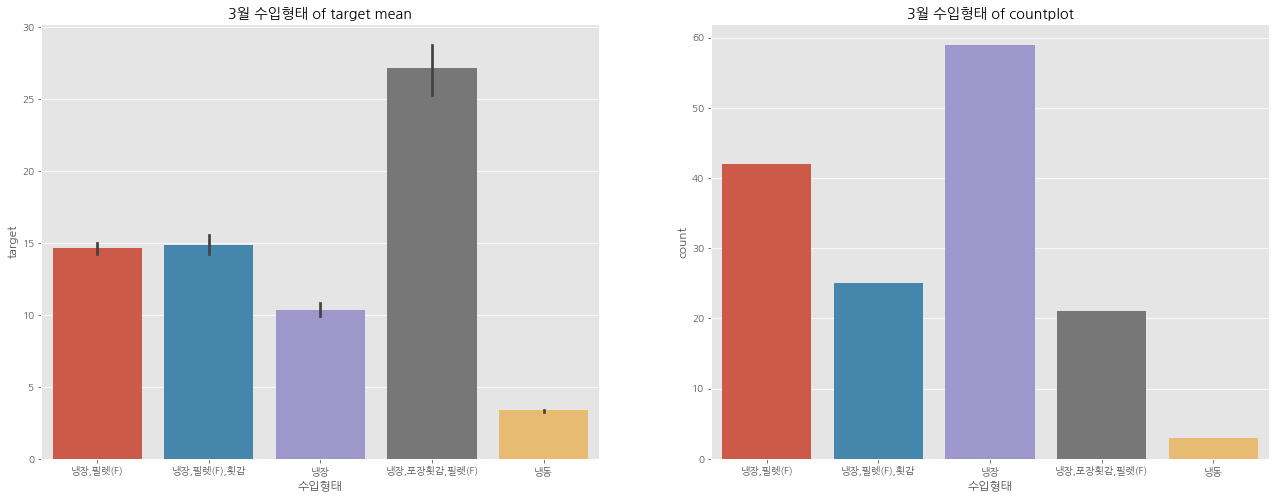

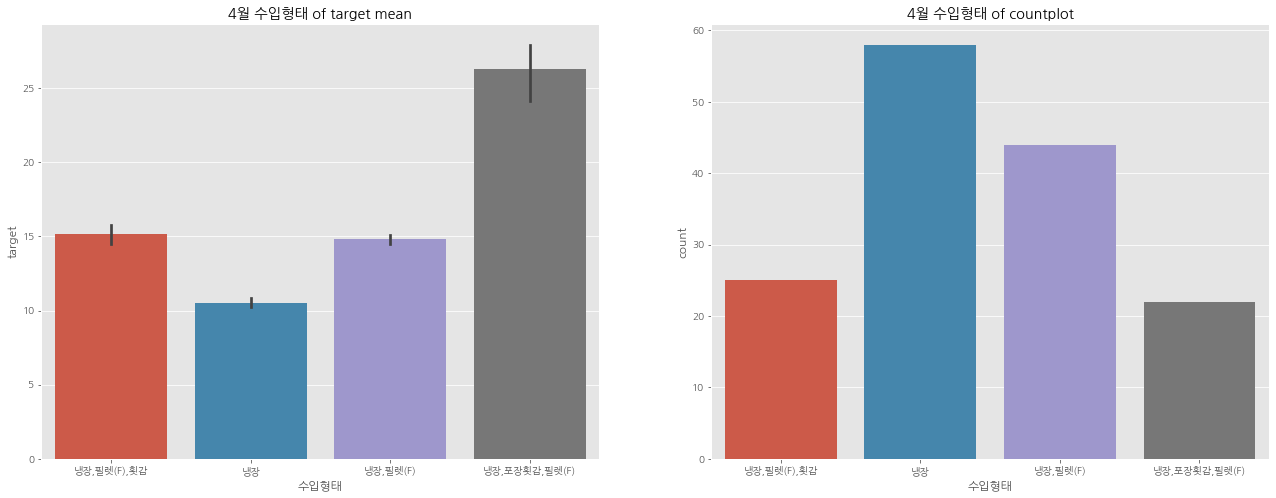

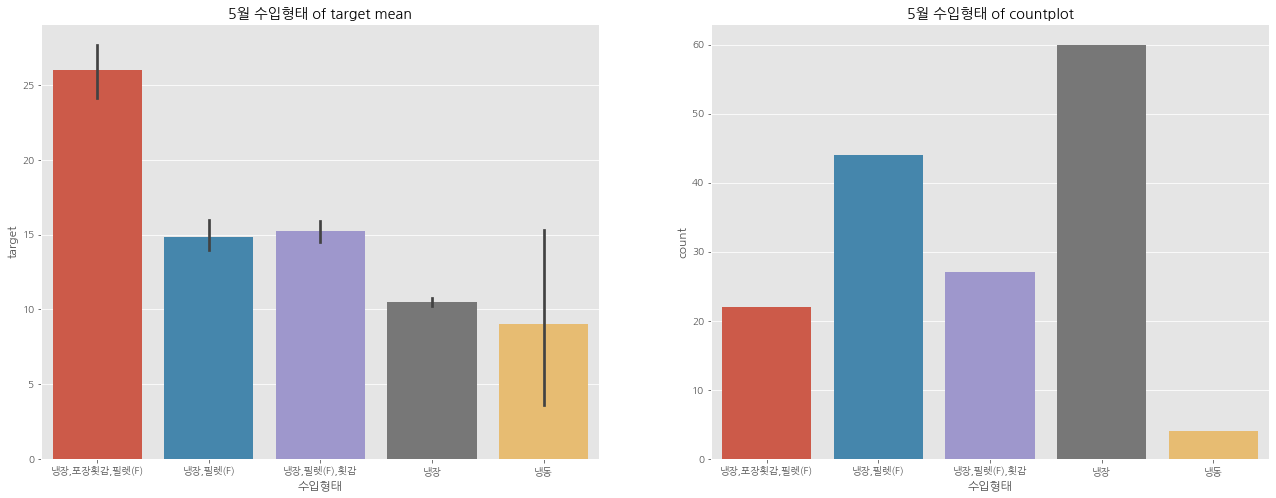

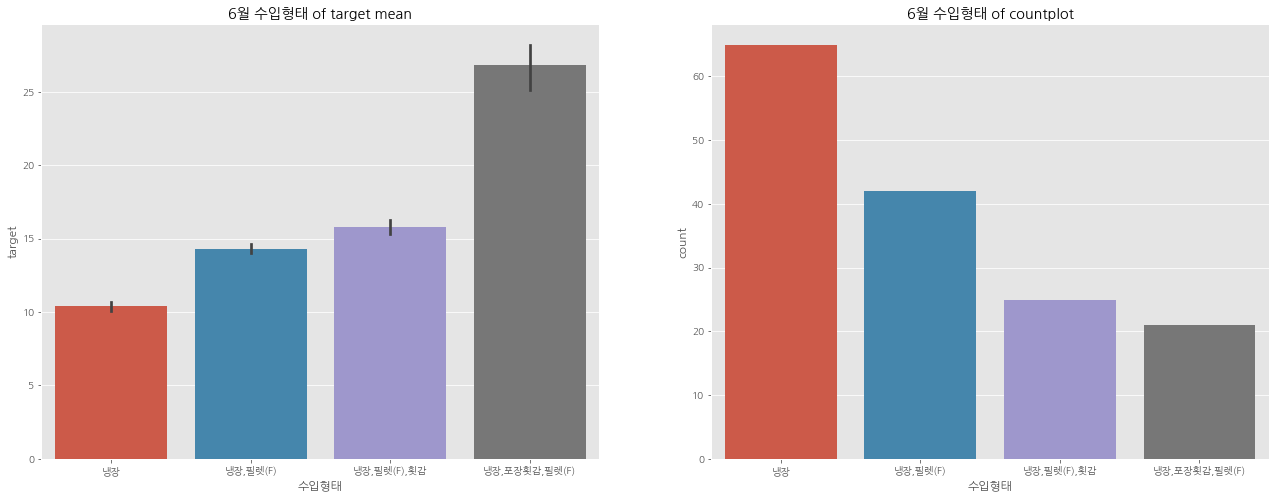

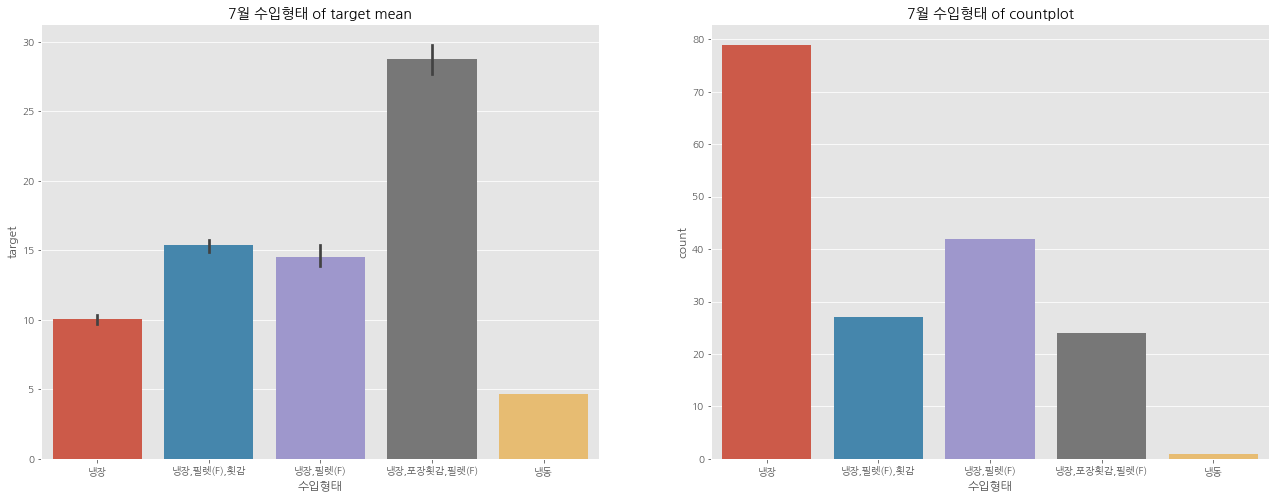

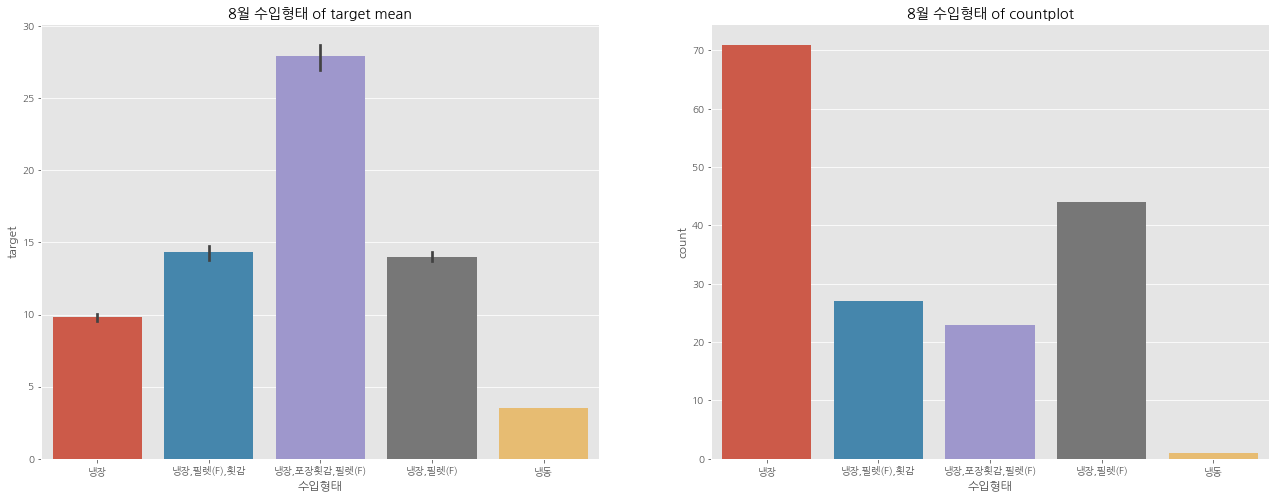

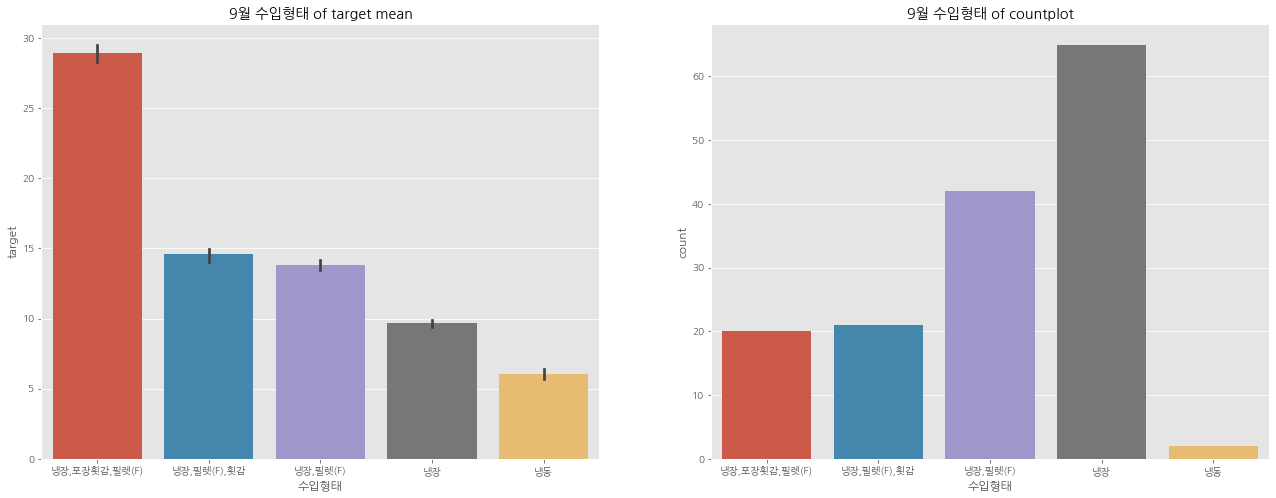

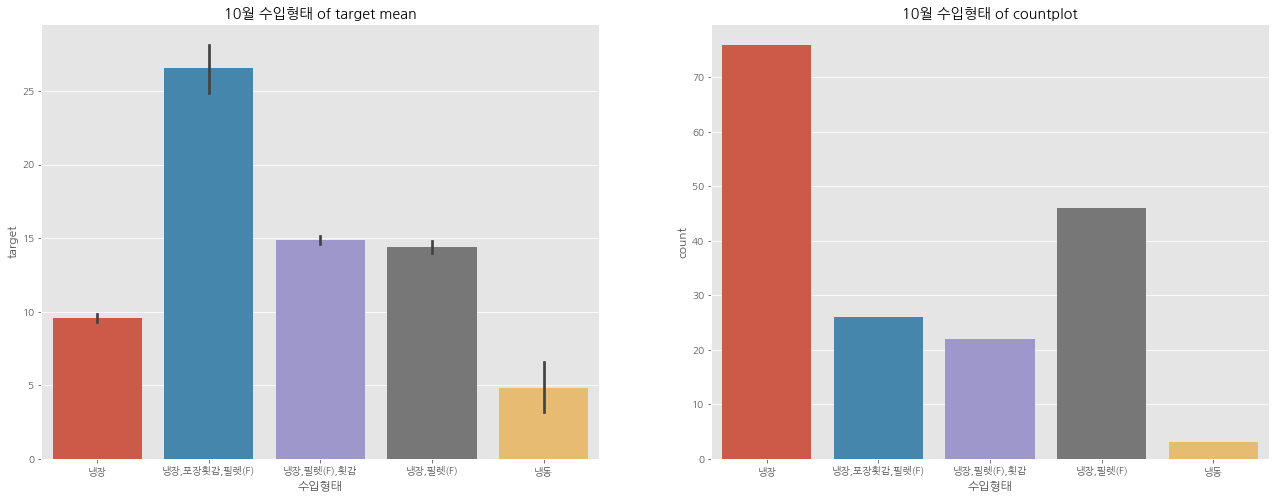

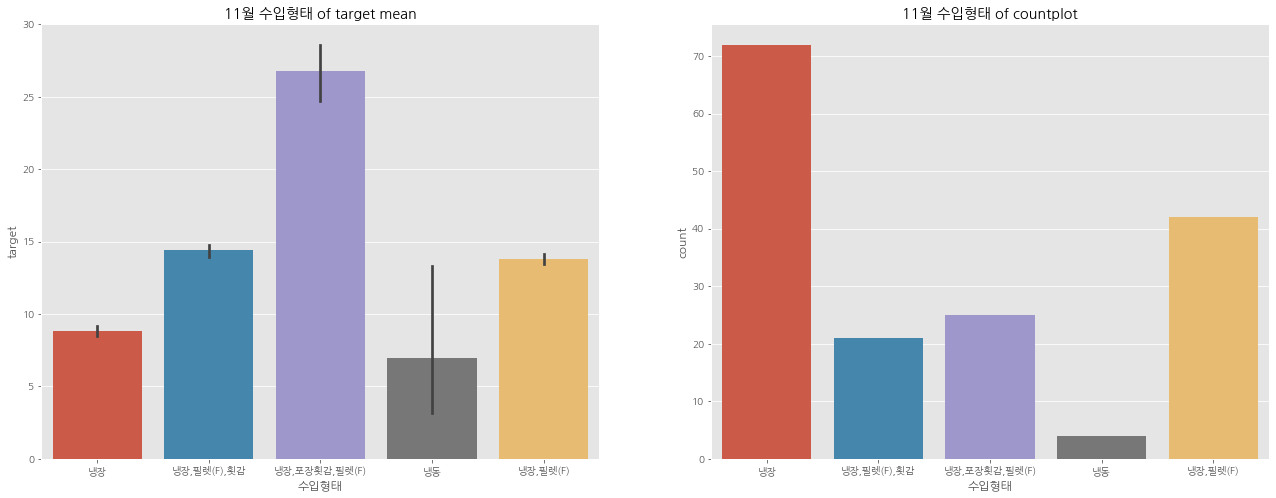

In [327]:
# month별 수입형태 확인해보기
for i in df['month'].unique():
  fig, ax = plt.subplots(ncols = 2,figsize = (22,8))
  sns.barplot(data = df[df['month'] == i], x = '수입형태', y = 'target', ax = ax[0])
  sns.countplot(df[df['month'] == i]['수입형태'], ax = ax[1])
  ax[0].set_title(f'{i}월 수입형태 of target mean')
  ax[1].set_title(f'{i}월 수입형태 of countplot')
  plt.show()

Text(0.5, 0, '')

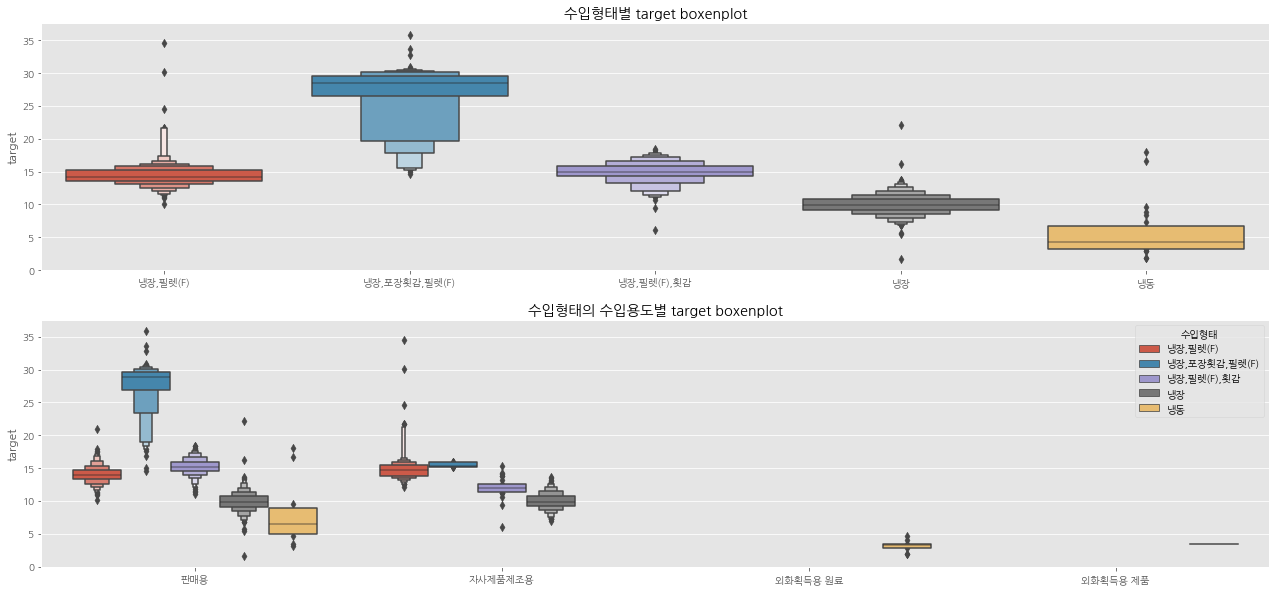

In [328]:
# 각 가격별 데이터를 확인해 보자.
fig, ax = plt.subplots(nrows = 2, figsize = (22,10))
sns.boxenplot(data = df, x = '수입형태', y = 'target', ax = ax[0])
# 수입용도의 평균가격을 수입형태 기준으로 살펴보자.
sns.boxenplot(data = df, x = '수입용도', y = 'target', hue = '수입형태', ax = ax[1])

ax[0].set_title('수입형태별 target boxenplot')
ax[1].set_title('수입형태의 수입용도별 target boxenplot')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

In [329]:
# 위의 그래프를 보면 IQR을 적용시켜 줄 때 수입형태별 수입용도를 기준으로 IQR을 시켜주도록 하자.
for i in df['수입형태'].unique():
  for j in df['수입용도'].unique():
    try:
      delete_index = get_outlier(df[(df['수입형태'] == i) & (df['수입용도'] == j)], column  = 'target', weight = 3.5)

      if len(delete_index) > 0:

        print(f'수입형태 : {i},  수입용도 : {j}, 제거되는 index : {delete_index}')

        df.loc[delete_index, 'target'] = np.nan

        for k in df.index:
          if k in delete_index:

            df.loc[k, 'target'] = df[(df['month'] == df.loc[k,'month']) & (df['수입용도'] == df.loc[k,'수입용도']) & (df['제조국'] == df.loc[k,'제조국'])]['target'].mean()
      
    except:
      pass

# 그러면 칠레의 데이터가 채워지지 않으므로 제거해준다.
df = df.dropna()

수입형태 : 냉장,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([1462], dtype='int64')
수입형태 : 냉장,필렛(F),  수입용도 : 자사제품제조용, 제거되는 index : Int64Index([313, 516, 523, 602, 1471], dtype='int64')
수입형태 : 냉장,포장횟감,필렛(F),  수입용도 : 판매용, 제거되는 index : Int64Index([15, 39, 60, 488], dtype='int64')
수입형태 : 냉장,필렛(F),횟감,  수입용도 : 자사제품제조용, 제거되는 index : Int64Index([31], dtype='int64')
수입형태 : 냉장,  수입용도 : 판매용, 제거되는 index : Int64Index([91, 212], dtype='int64')


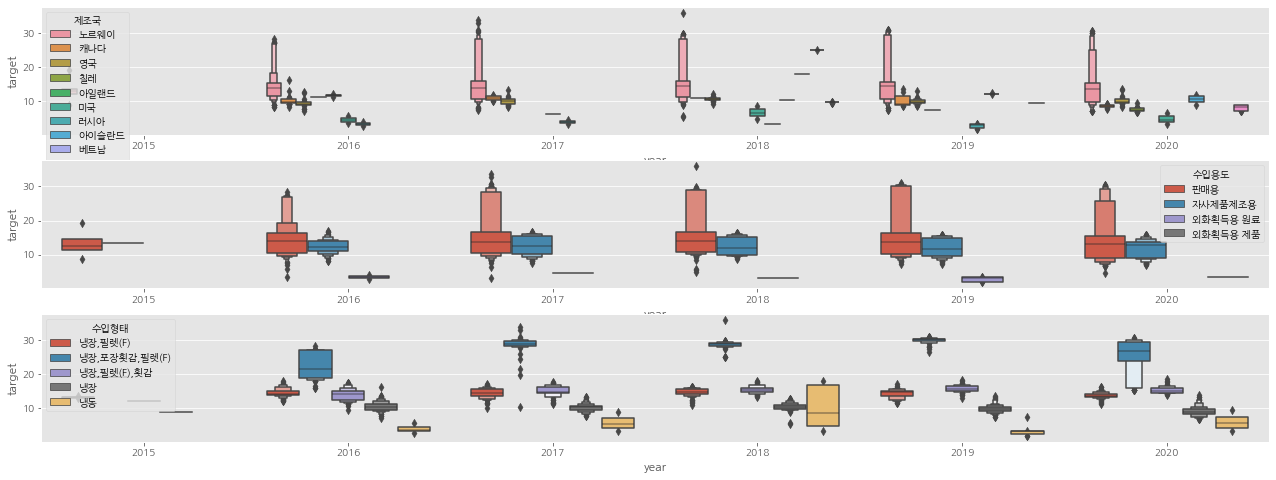

In [330]:
# 연별로 데이터의 이상치를 확인해 보자.
fig, ax = plt.subplots(nrows = 3, figsize = (22,8))
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '제조국', ax = ax[0])
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '수입용도', ax = ax[1])
sns.boxenplot(data = df, x = 'year', y = 'target', hue = '수입형태', ax = ax[2])

In [331]:
df.head()

,기준일,제조국,수출국,수입용도,수입형태,target,year,month,day,week,냉동,횟감,필렛(F),냉장,포장횟감
0,2015-12-28,노르웨이,노르웨이,판매용,"냉장,필렛(F)",12.936815,2015,12,28,53,0,0,1,1,0
1,2015-12-28,노르웨이,노르웨이,판매용,"냉장,포장횟감,필렛(F)",19.146755,2015,12,28,53,0,0,1,1,1
2,2015-12-28,노르웨이,노르웨이,판매용,"냉장,필렛(F),횟감",12.082384,2015,12,28,53,0,1,1,1,0
3,2015-12-28,노르웨이,노르웨이,자사제품제조용,"냉장,필렛(F)",13.425826,2015,12,28,53,0,0,1,1,0
4,2015-12-28,노르웨이,노르웨이,판매용,냉장,8.844281,2015,12,28,53,0,0,0,1,0


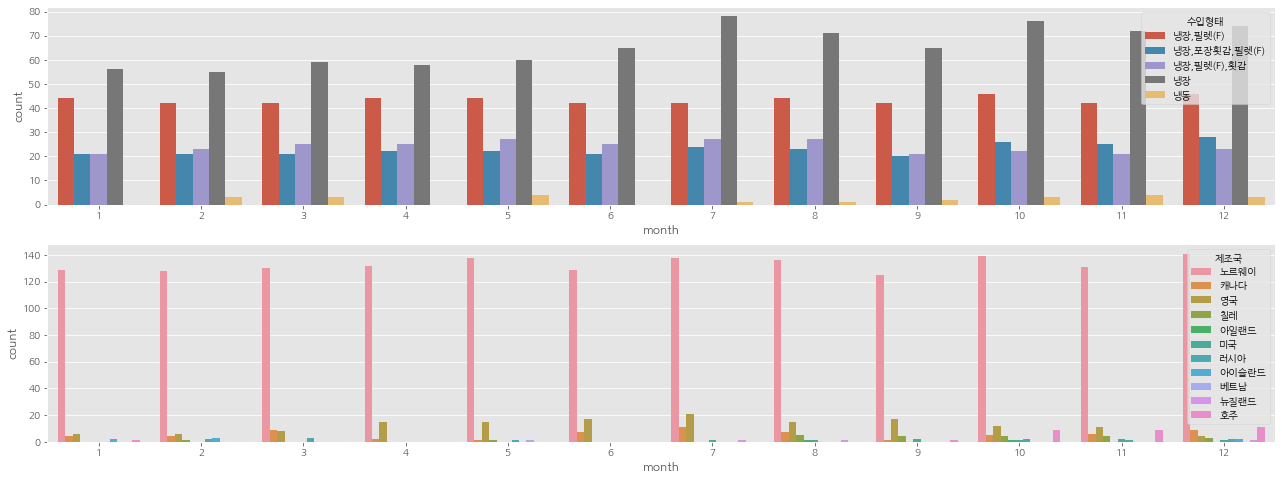

In [332]:
# 그래프를 그려보면서 month별로 수입형태, 제조국에 차이가 있는지 확인한다.
fig, ax = plt.subplots(nrows = 2, figsize = (22,8))
sns.countplot(data = df, x = 'month', hue = '수입형태', ax = ax[0])
sns.countplot(data = df, x = 'month', hue = '제조국', ax = ax[1])

In [333]:
# 제조국을 노르웨이 or 그 이외의 국가
df['제조국'] = df['제조국'].apply(lambda x:x if x == '노르웨이' else '그 이외의 국가')

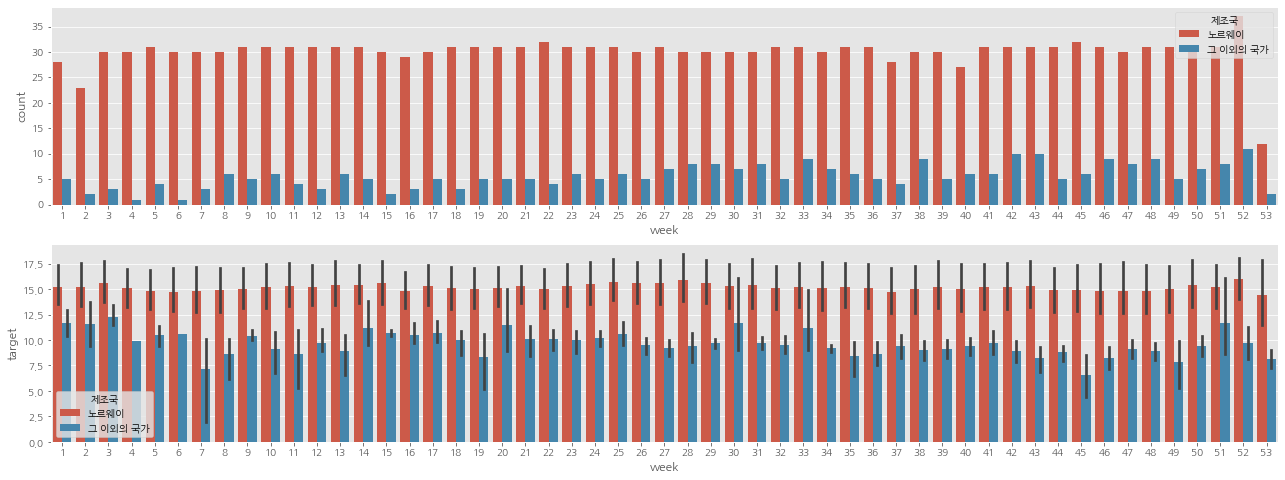

In [334]:
# 제조국
fig, ax = plt.subplots(nrows = 2, figsize = (22,8))
sns.countplot(data = df, x = 'week', hue = '제조국', ax = ax[0])
sns.barplot(data =df, x = 'week', y = 'target', hue = '제조국', ax = ax[1])

In [335]:
제조국_df = pd.get_dummies(df, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','month']]

제조국_df = 제조국_df.groupby('month').mean().reset_index()

In [336]:
# 제조국으로 할수 있는 최대한인가? 하하...
qwe = pd.get_dummies(df, columns = ['제조국'], drop_first = True)[['기준일','제조국_노르웨이','week']]
std_노르웨이 = qwe.groupby('week').std().reset_index()[['week','제조국_노르웨이']]
mean_노르웨이 = qwe.groupby('week').mean().reset_index()[['week','제조국_노르웨이']]

# 내일 이 부분을 좀 더 봐보자.
# 그리고 판매용과 자사제품 제조용 외화획득용 원료를 살펴보도록 하자.

In [337]:
# 더미화를 진행해 준 이후에 평균/std를 해주었다.
수입형태_df = pd.get_dummies(data = df, columns = ['수입형태'])[['기준일','수입형태_냉장', '수입형태_냉장,포장횟감,필렛(F)','수입형태_냉장,필렛(F)', '수입형태_냉장,필렛(F),횟감','수입형태_냉동','week']]
수입형태_df_mean = 수입형태_df.groupby('week').mean().reset_index()[['수입형태_냉장', '수입형태_냉장,포장횟감,필렛(F)','수입형태_냉장,필렛(F)', '수입형태_냉장,필렛(F),횟감','수입형태_냉동','week']]
수입형태_df_std = 수입형태_df.groupby('week').std().reset_index()[['수입형태_냉장', '수입형태_냉장,포장횟감,필렛(F)','수입형태_냉장,필렛(F)', '수입형태_냉장,필렛(F),횟감','수입형태_냉동','week']]

In [338]:
# 수입형태의 빈도수를 계산한다.
수입형태_mean = df.groupby('week').mean()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()
수입형태_std = df.groupby('week').std()[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']].reset_index()

수입형태_변형 = 수입형태_mean[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']]/(수입형태_std[['냉장', '필렛(F)', '횟감', '포장횟감', '냉동']]+1)
수입형태_변형['week'] = 수입형태_mean['week']
수입형태_변형

,냉장,필렛(F),횟감,포장횟감,냉동,week
0,1.000000,0.362272,0.091039,0.091039,0.000000,1
1,1.000000,0.400000,0.090113,0.116434,0.000000,2
2,1.000000,0.405067,0.111073,0.111073,0.000000,3
3,1.000000,0.459208,0.138090,0.117398,0.000000,4
4,1.000000,0.400788,0.124009,0.105427,0.000000,5
5,1.000000,0.434051,0.117398,0.117398,0.000000,6
6,0.756170,0.405067,0.111073,0.111073,0.048785,7
7,0.833333,0.369397,0.102825,0.102825,0.023810,8
8,1.000000,0.388889,0.120951,0.102825,0.000000,9
9,0.835601,0.377812,0.118049,0.100354,0.023211,10


In [339]:
# 외화획득용 제품이라 되어있는 부분을 외화획득용 원료로 바꿔준다.
df['수입용도'] = df['수입용도'].apply(lambda x:'외화획득용 원료' if x == '외화획득용 제품' else x)

# 수입용도로 데이터를 살펴보기로 하자.
수입용도_df = pd.get_dummies(data = df, columns = ['수입용도']).reset_index()[['기준일','week','수입용도_판매용','수입용도_자사제품제조용','수입용도_외화획득용 원료']]
수입용도_df = 수입용도_df.groupby('week').mean().reset_index()
수입용도_df

,week,수입용도_판매용,수입용도_자사제품제조용,수입용도_외화획득용 원료
0,1,0.696970,0.303030,0.000000
1,2,0.640000,0.360000,0.000000
2,3,0.696970,0.303030,0.000000
3,4,0.677419,0.322581,0.000000
4,5,0.685714,0.314286,0.000000
5,6,0.677419,0.322581,0.000000
6,7,0.666667,0.303030,0.030303
7,8,0.694444,0.277778,0.027778
8,9,0.694444,0.305556,0.000000
9,10,0.675676,0.297297,0.027027


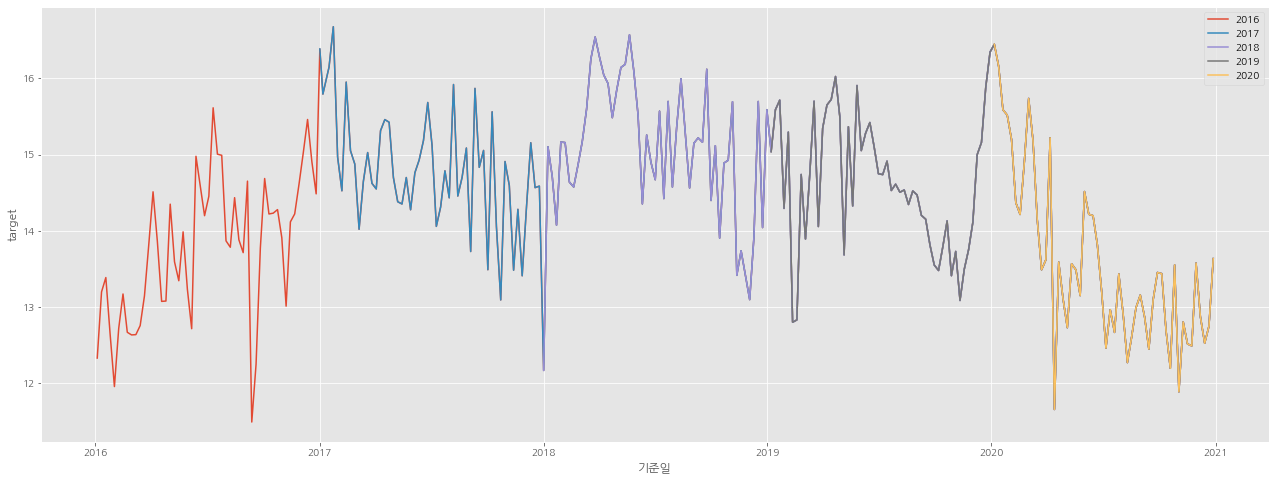

In [340]:
# 연별로 차이가 있는지 확인하는게 먼저인가?
year = ['2016','2017','2018','2019','2020']
plot_data = df.groupby('기준일')['target'].mean().reset_index()

year_dict = {}
for i in range(len(year)):
  if i == '2016':
    year_dict[year[i]] = plot_data[plot_data['기준일'] < year[i+1]]

  elif i in ['2017','2018','2019']:

    year_dict[year[i]] = plot_data[(plot_data['기준일'] >= year[i]) & (plot_data['기준일'] < year[i+1])]

  else:
    year_dict[year[i]] = plot_data[plot_data['기준일'] >= year[i]]

plt.figure(figsize= (22,8))
for idx, value in year_dict.items():
  sns.lineplot(data = value, x = '기준일', y = 'target')

plt.legend(labels = [i for i in year_dict.keys()])
plt.show()

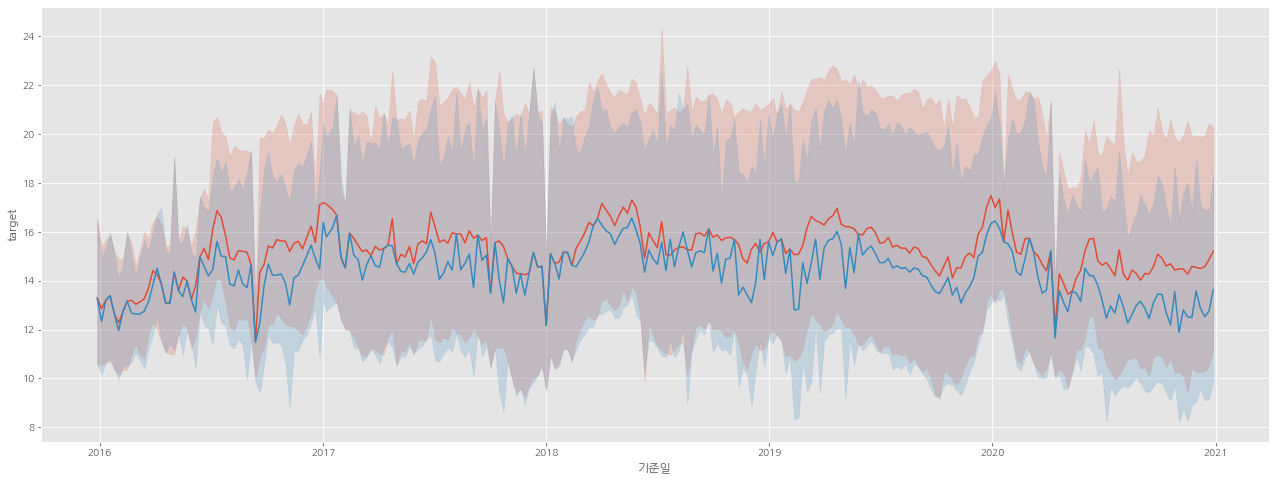

In [341]:
# 나라별로 데이터를 살펴보기로 하자.
plt.figure(figsize = (22,8))
sns.lineplot(data = df[df['제조국'] == '노르웨이'], x = '기준일', y = 'target')
sns.lineplot(data = df, x = '기준일', y = 'target')
plt.show()

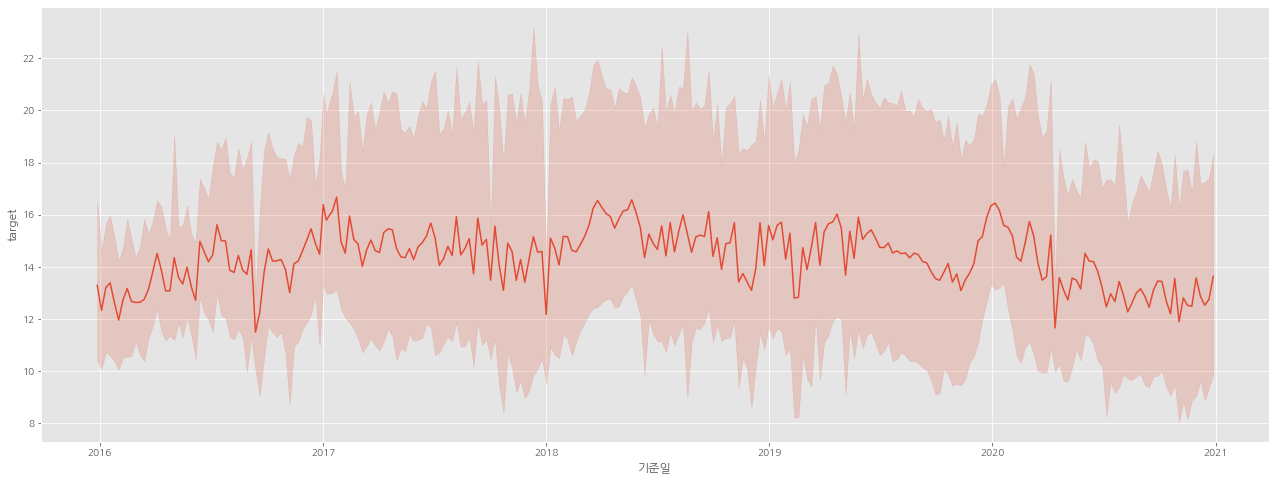

In [342]:
# 영국도 관련이 없다고 생각된다.
plt.figure(figsize = (22,8))
sns.lineplot(data = df[df['제조국'] == '영국'], x = '기준일', y = 'target')
sns.lineplot(data = df, x = '기준일', y = 'target')
plt.show()

## 환율

In [343]:
def load_currency(PATH, country = None):
    
    # 경로를 입력해주면 해당 경로에 저장된 환율 데이터 불러오기
    currency_data = pd.read_csv(PATH)

    # Date 변수가 문자형 타입으로 저장되어 있기 때문에, 날짜형으로 변환
    currency_data['Date'] = pd.to_datetime(currency_data['Date'])

    # 날짜를 기준으로 하여 오름차순으로 정렬해주도록 한다.
    currency_data = currency_data.sort_values(by = 'Date', ignore_index = True)

    # 한 주마다 환율의 평균을 구해줘야 하기 때문에 '기준일'을 나타내는 변수를 생성해주도록 한다.
    currency_data['기준일'] = np.repeat(pd.date_range(start = '2015-12-28', end = '2021-07-04', freq = '7D'), 7)

    # 기준일 변수를 기준으로 하여 한 주의 평균 환율을 구해주도록 한다.
    return_data = pd.pivot_table(currency_data, index = '기준일', values = country).reset_index()

    return return_data

In [344]:
환율데이터 = load_currency('/content/drive/MyDrive/빅콘테스트/환율데이터.csv',country = ['노르웨이','대한민국'])

Text(0.5, 0, '')

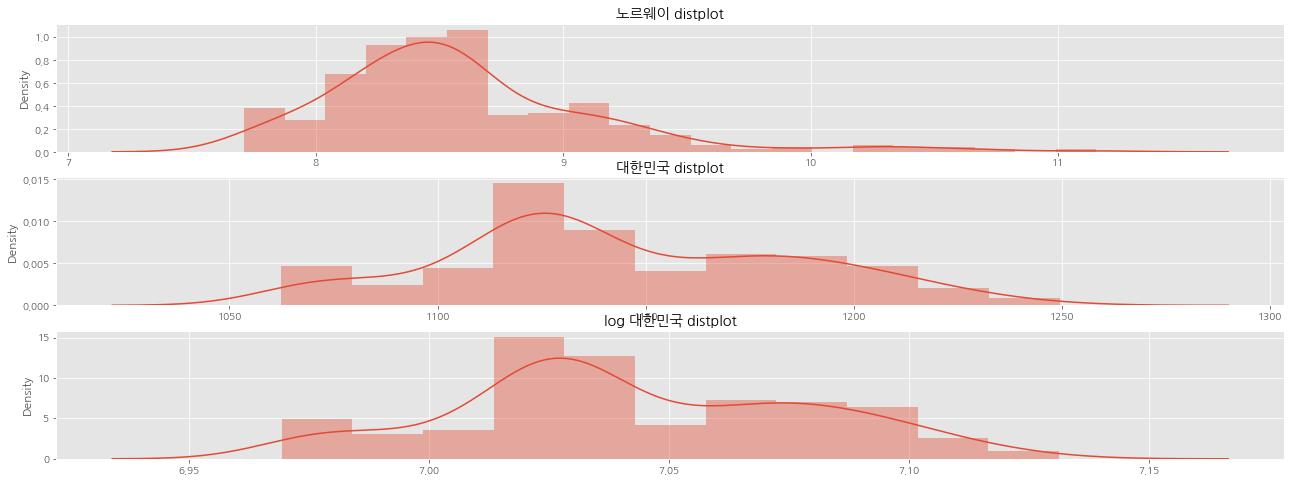

In [345]:
# 환율데이터가 얼마나 데이터와 맞게 따라가는지 확인해 보자
fig, ax = plt.subplots(nrows = 3, figsize = (22,8))
sns.distplot(환율데이터['노르웨이'], ax = ax[0])
sns.distplot(환율데이터['대한민국'], ax = ax[1])
sns.distplot(환율데이터['대한민국'].apply(lambda x: np.log1p(x)), ax = ax[2])

ax[0].set_title('노르웨이 distplot')
ax[1].set_title('대한민국 distplot')
ax[2].set_title('log 대한민국 distplot')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

## 유가 주식 데이터

In [346]:
!pip install yfinance

# Modeling data

## train VS val

In [347]:
# 환율데이터 train_val에만 사용할 데이터를 가져온다.
train_val_환율 = 환율데이터[환율데이터['기준일'] < '2021'].reset_index()

In [348]:
# 데이터를 groupby를 사용하여 기준일 별 데이터를 가져온다.
data = df.groupby('기준일').mean().reset_index()[['기준일','target','month','week']]
data = pd.concat([data, train_val_환율[['대한민국','노르웨이']]], axis = 1)

data = pd.merge(data, 수입형태_df_mean ,how ='left', on = 'week') 
# data = pd.merge(data, 수입형태_df_std, how = 'left', on = 'month')
# data = pd.merge(data, std_노르웨이, how = 'left', on = 'month')
data = pd.merge(data, 수입형태_변형, how = 'left', on = 'week')
data = pd.merge(data, mean_노르웨이, how = 'left', on = 'week')
data = pd.merge(data, 수입용도_df, how = 'left', on = 'week')
data.drop(['month','week'], axis = 1, inplace = True)
# data = pd.get_dummies(data, columns = ['month'])

data['대한민국'] = data['대한민국'].apply(lambda x: np.log1p(x))

In [349]:
train = data[data['기준일'] < '2020']
val = data[(data['기준일'] >= '2020') & (data['기준일'] < '2020-07')]

In [350]:
val

,기준일,target,대한민국,노르웨이,수입형태_냉장,"수입형태_냉장,포장횟감,필렛(F)","수입형태_냉장,필렛(F)","수입형태_냉장,필렛(F),횟감",수입형태_냉동,냉장,필렛(F),횟감,포장횟감,냉동,제조국_노르웨이,수입용도_판매용,수입용도_자사제품제조용,수입용도_외화획득용 원료
210,2020-01-06,16.445297,7.057632,8.867201,0.400000,0.160000,0.320000,0.120000,0.000000,1.000000,0.400000,0.090113,0.116434,0.000000,0.920000,0.640000,0.360000,0.000000
211,2020-01-13,16.157032,7.055513,8.892396,0.393939,0.151515,0.303030,0.151515,0.000000,1.000000,0.405067,0.111073,0.111073,0.000000,0.909091,0.696970,0.303030,0.000000
212,2020-01-20,15.587532,7.062570,9.006621,0.322581,0.161290,0.322581,0.193548,0.000000,1.000000,0.459208,0.138090,0.117398,0.000000,0.967742,0.677419,0.322581,0.000000
213,2020-01-27,15.516672,7.079042,9.174780,0.400000,0.142857,0.285714,0.171429,0.000000,1.000000,0.400788,0.124009,0.105427,0.000000,0.885714,0.685714,0.314286,0.000000
214,2020-02-03,15.199548,7.080486,9.262211,0.354839,0.161290,0.322581,0.161290,0.000000,1.000000,0.434051,0.117398,0.117398,0.000000,0.967742,0.677419,0.322581,0.000000
215,2020-02-10,14.370685,7.075848,9.252215,0.333333,0.151515,0.303030,0.151515,0.060606,0.756170,0.405067,0.111073,0.111073,0.048785,0.909091,0.666667,0.303030,0.030303
216,2020-02-17,14.214829,7.089341,9.295482,0.416667,0.138889,0.277778,0.138889,0.027778,0.833333,0.369397,0.102825,0.102825,0.023810,0.833333,0.694444,0.277778,0.027778
217,2020-02-24,14.908977,7.097451,9.388732,0.416667,0.138889,0.277778,0.166667,0.000000,1.000000,0.388889,0.120951,0.102825,0.000000,0.861111,0.694444,0.305556,0.000000
218,2020-03-02,15.735015,7.080047,9.300897,0.405405,0.135135,0.270270,0.162162,0.027027,0.835601,0.377812,0.118049,0.100354,0.023211,0.837838,0.675676,0.297297,0.027027
219,2020-03-09,15.187748,7.092861,9.902588,0.371429,0.142857,0.285714,0.171429,0.028571,0.830969,0.400788,0.124009,0.105427,0.024440,0.885714,0.657143,0.314286,0.028571


In [351]:
!pip install catboost

In [352]:
!pip install vecstack

[13:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
***************************lightgbm의 그래프**************************


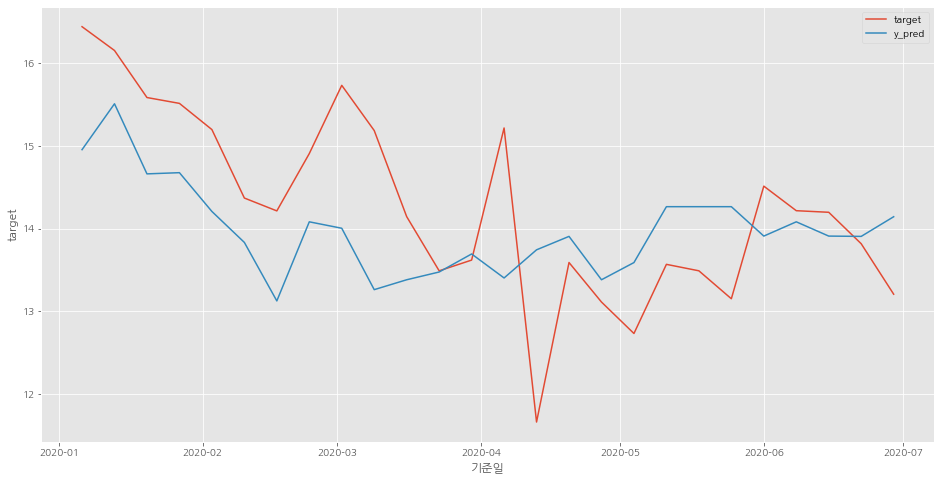

lightgbm의 RMSE : 1.0166774210894187
lightgbm의 r^2 score : 0.17462096342747158
***************************xgboost의 그래프**************************


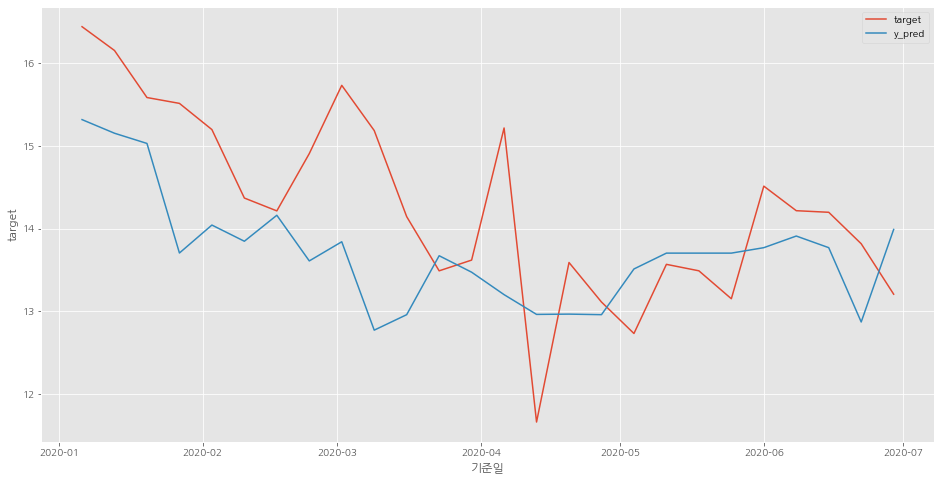

xgboost의 RMSE : 1.0663533838398895
xgboost의 r^2 score : 0.09199261687809934
***************************catboost의 그래프**************************


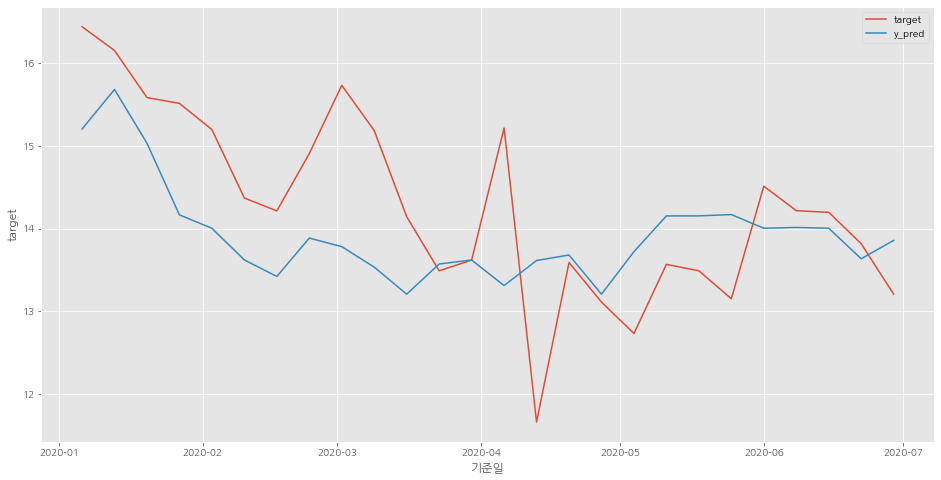

catboost의 RMSE : 1.0014526042964138
catboost의 r^2 score : 0.19915608962150289
***************************lr의 그래프**************************


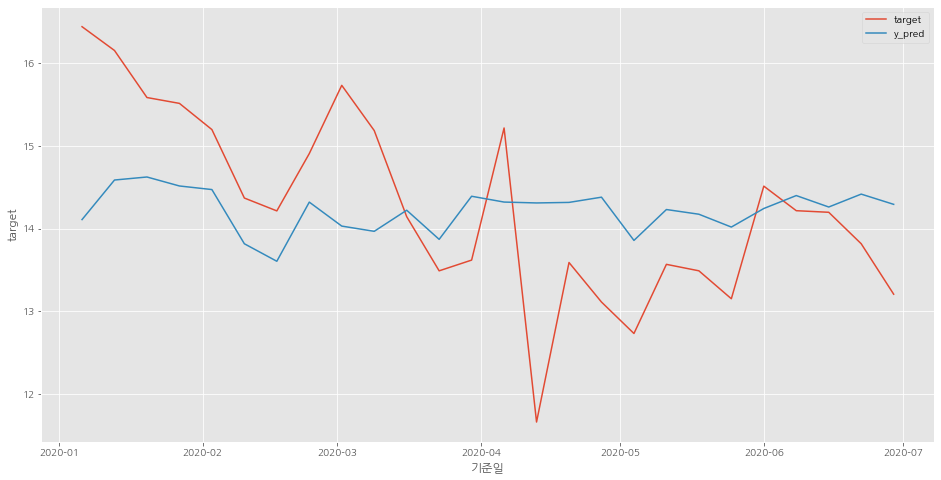

lr의 RMSE : 1.0937921308246472
lr의 r^2 score : 0.0446628506174771
***************************ridge의 그래프**************************


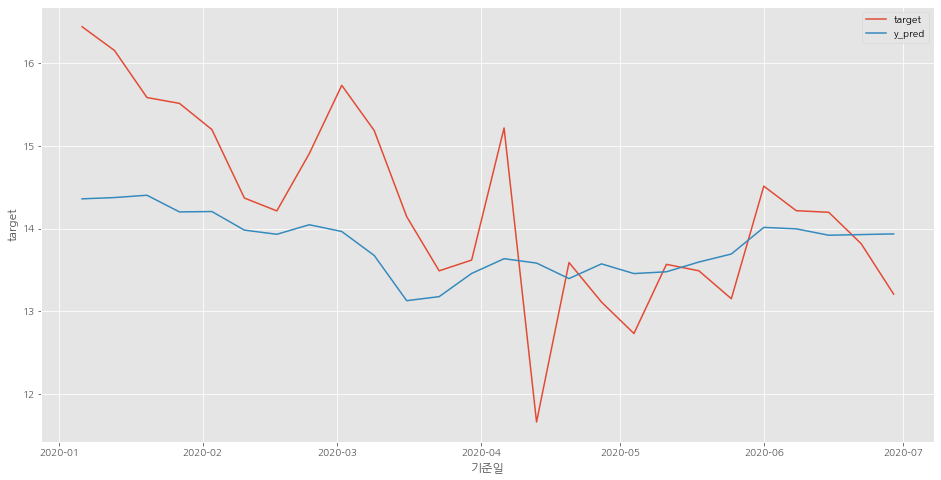

ridge의 RMSE : 1.0265627899185361
ridge의 r^2 score : 0.15849226276955175
***************************lasso의 그래프**************************


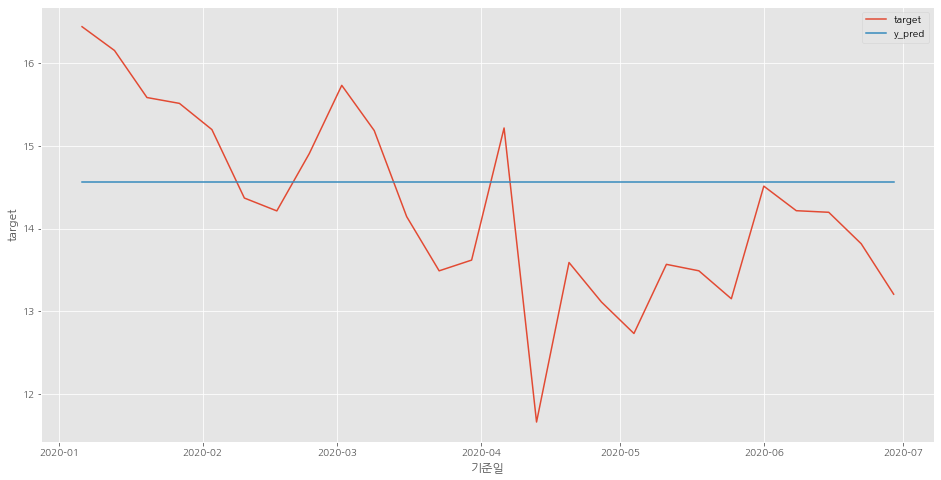

lasso의 RMSE : 1.1556104907965798
lasso의 r^2 score : -0.06637518066652248
***************************rfg의 그래프**************************


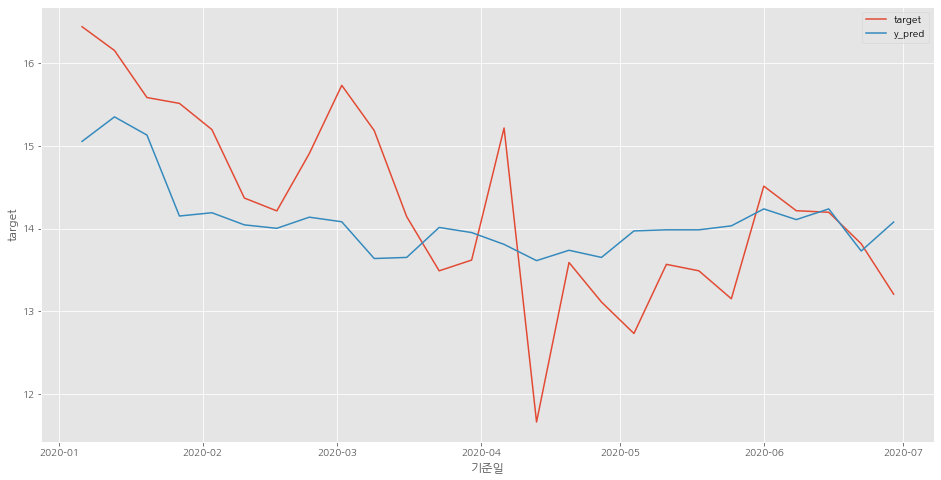

rfg의 RMSE : 0.9173915674302711
rfg의 r^2 score : 0.32795776939333
***************************gb의 그래프**************************


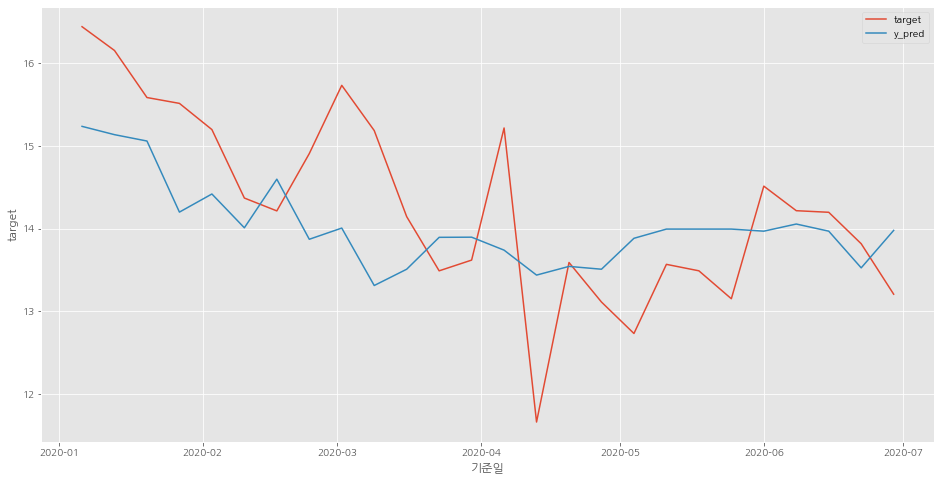

gb의 RMSE : 0.9337978328509199
gb의 r^2 score : 0.30370576349608513


In [353]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from vecstack import stacking

def run_model(train_data = None, val_data = None):

  train_data = train_data.reset_index(drop = True)
  val_data = val_data.reset_index(drop = True)

  X_train, y_train = train_data.drop(['기준일','target'], axis = 1), train_data['target']
  X_test, y_test = val_data.drop(['기준일','target'], axis = 1), val_data['target']

  models = {'lightgbm':LGBMRegressor(random_state = 42), 'xgboost':XGBRegressor(random_state = 42),'catboost': CatBoostRegressor(random_state = 42, verbose = False),'lr': LinearRegression(),
            'ridge': Ridge(random_state = 42),'lasso': Lasso(),'rfg':RandomForestRegressor(random_state = 42),'gb':GradientBoostingRegressor(random_state = 42)}


  final_y_pred = {}
  for i, j in models.items():
    model = j
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred = pd.Series(y_pred)

    validation_data = pd.concat([val_data[['기준일','target']],y_pred], axis = 1).rename(columns = {0 : 'y_pred'}).groupby('기준일').mean()

    final_y_pred[i] = validation_data

  for i, j in final_y_pred.items():
    print(f'***************************{i}의 그래프**************************')

    plt.figure(figsize = (16,8))
    sns.lineplot(data =j , x = '기준일', y = 'target')
    sns.lineplot(data =j, x = '기준일', y = 'y_pred')
    plt.legend(labels = ['target','y_pred'])
    plt.show()

    print(f'{i}의 RMSE :', mean_squared_error(j['target'], j['y_pred']) ** 0.5)
    print(f'{i}의 r^2 score :', r2_score(j['target'], j['y_pred']))

run_model(train_data = train, val_data = val)

In [354]:
# Stacking Ensemble
def rmse(y, y_pred):

  return np.sqrt(mean_squared_error(y, y_pred))

lgb = LGBMRegressor(random_state =42)
xgb = XGBRegressor(random_state = 42, tree_method = 'gpu_hist')
catboost = CatBoostRegressor(random_state =42, task_type = 'GPU', verbose = False)
rfg = RandomForestRegressor(random_state = 42)
ridge = Ridge(random_state = 42)
lr = LinearRegression()
gb = GradientBoostingRegressor(random_state = 42)
lasso = Lasso(random_state = 42)

X_train, y_train = train.drop(['기준일','target'], axis = 1), train['target']
X_test, y_test = val.drop(['기준일','target'], axis = 1), val['target']

models = [lgb,xgb, catboost, ridge, rfg,lr, gb, lasso]

S_train, S_test = stacking(models, X_train, y_train, X_test, regression = True, mode = 'oof_pred_bag', metric  = rmse, n_folds =3, random_state = 42)

lgb = CatBoostRegressor(random_state = 42, verbose = False)
lgb.fit(S_train, y_train)
y_pred = lgb.predict(S_test)
RMSE = mean_squared_error(y_test, y_pred) **0.5

print('R^2 score :',r2_score(y_test, y_pred))
print('rmse score :',RMSE)

[13:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score : 0.287178954499681
rmse score : 0.9448148665300488


In [355]:
# Voting Ensemble
from sklearn.ensemble import VotingRegressor

lr = LinearRegression()
lgb = LGBMRegressor(random_state = 42)
cat = CatBoostRegressor(random_state = 42,verbose = False, task_type = 'GPU')
xgb = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
ridge = Ridge(random_state = 42)
rfg = RandomForestRegressor(random_state = 42)
gb = GradientBoostingRegressor(random_state = 42)


vo_reg = VotingRegressor(estimators = [('lr',lr),('lgb',lgb),('cat',cat),('xgb',xgb),('ridge',ridge),('rfg',rfg),('gb',gb)], n_jobs = 3)
vo_reg.fit(X_train, y_train)
y_pred = vo_reg.predict(X_test)

RMSE = rmse(y_test, y_pred)

print('R^2 score :',r2_score(y_test, y_pred))
print('rmse score :',RMSE)

R^2 score : 0.26280568449481057
rmse score : 0.9608319818217076


In [356]:
# statsmodel을 사용하여 통계적 지표로 확인해 보자.
import statsmodels.api as sm

X = sm.add_constant(data.drop(['기준일','target'], axis = 1))
y = data['target']

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.854
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           6.53e-08
Time:                        13:50:11   Log-Likelihood:                -363.02
No. Observations:                 262   AIC:                             756.0
Df Residuals:                     247   BIC:                             809.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 34.4343    158

# LSTM (모델을 어떻게 구축하는지 모르겠다)

In [357]:
# data.columns

In [358]:
# TEST_SIZE = len(data[(data['기준일'] >= '2020') & (data['기준일'] < '2020-07')])

# train = data[:TEST_SIZE]
# val = data[-TEST_SIZE:]

# def make_dataset(data, label, window_size = 20):
#   feature_list = []
#   label_list = []

#   for i in range(len(data) - window_size):
#     feature_list.append(np.array(data.iloc[i : i+window_size]))
#     label_list.append(np.array(label.iloc[i+window_size]))

#   return np.array(feature_list), np.array(label_list)

# from sklearn.model_selection import train_test_split

# feature_cols = ['대한민국', '노르웨이', '수입형태_냉장', '수입형태_냉장,포장횟감,필렛(F)',
#        '수입형태_냉장,필렛(F)', '수입형태_냉장,필렛(F),횟감', '수입형태_냉동', '제조국_노르웨이_x',
#        '제조국_노르웨이_y', 'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0',
#        'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0',
#        'month_10.0', 'month_11.0', 'month_12.0']

# label_cols = ['target']

# train_feature = train[feature_cols]
# train_label = train[label_cols]

# train_feature, train_label = make_dataset(train_feature, train_label, 20)

# val_feature = val[feature_cols]
# val_label = val[label_cols]

# val_feature, val_label = make_dataset(val_feature, val_label, 20)

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import LSTM

# model = Sequential()
# model.add(LSTM(16,
#                input_shape = (train_feature.shape[1], train_feature.shape[2]),
#                activation = 'relu',
#                return_sequences = False))
# model.add(Dense(1))

# model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# history = model.fit(train_feature, train_label, epochs = 200, batch_size = 1, validation_data = (val_feature, val_label))

# pred = model.predict(val_feature)
# pred.shape

In [359]:
# plt.figure(figsize=(12, 9))
# plt.plot(val_label, label = 'actual')
# plt.plot(pred, label = 'prediction')
# plt.legend()
# plt.show()